# Ghana seasonal P in CMIP6 models 
## Calculate climatolgical seasonal P over Ghana country shapefile in CMIP6 models
Author: Jess Baker, j.c.baker@leeds.ac.uk


In [6]:
import numpy as np
import pandas as pd
import iris
import iris.coord_categorisation
import matplotlib.pyplot as plt
from matplotlib.path import Path
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import xarray as xr
import glob
import shapefile
from datetime import datetime
from scipy.stats import pearsonr

In [2]:
# function to extract data from shapefile
def clip_to_shapefile(data, data_lat, data_lon, shp_path, shp):

    # Load a shapefile
    sf = shapefile.Reader(shp_path+shp)

    # Extract coordinates from shapefile
    for shape_rec in sf.shapeRecords():
        mask_lons = []
        mask_lats = []
        pts = shape_rec.shape.points
        prt = list(shape_rec.shape.parts) + [len(pts)]
        for i in range(len(prt) - 1):
            for j in range(prt[i], prt[i+1]):
                mask_lons.append(pts[j][0])
                mask_lats.append(pts[j][1])

    # Determine mask and apply to data
    # Vertices of extraction domain
    coordlist = np.vstack((mask_lons, mask_lats)).T

    # Co-ordinates of every grid cell
    dat_x, dat_y = np.meshgrid(data_lon, data_lat)
    coord_map = np.vstack((dat_x.flatten(), dat_y.flatten())).T
    polypath = Path(coordlist)

    # Work out which coords are within the polygon
    mask = polypath.contains_points(coord_map).reshape(dat_x.shape)
#    print(mask.shape)
    clipped_data = data[:,:][mask]
    #print(clipped_data.shape)
    return(clipped_data)
    #plt.plot(test)
    
    
def get_dates(cube, verbose=False):
    dates = cube.coord('time').units.num2date(cube.coord('time').points)
    dates = [datetime(date.year, date.month, date.day) for date in dates]
    if verbose is True:
        print(dates)
    else:
        print(dates[0], '–', dates[-1])
    return(dates)

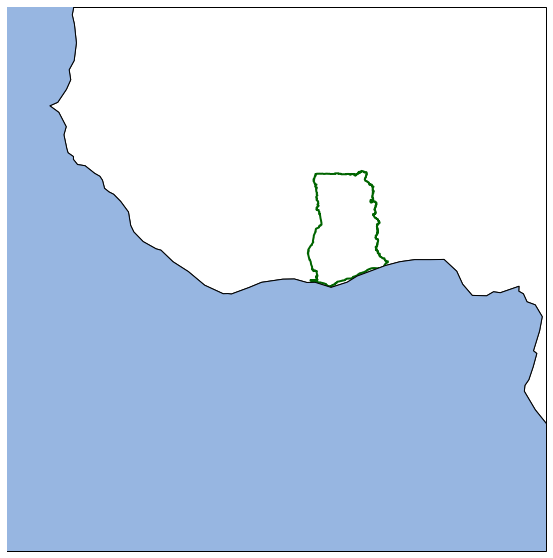

In [3]:
# plot shapefile of Ghana outline
shp_path = '/gws/pw/j05/cop26_hackathons/leeds/ministry/jess/ghana_shapefiles/'

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection=ccrs.Mercator())
ax.set_extent([-20, 10, -10, 20], ccrs.PlateCarree())
ax.add_feature(cartopy.feature.OCEAN, zorder=100, edgecolor='k')
ax.coastlines()
ax.add_geometries(Reader(shp_path+'gha_admbnda_adm0_gss_20210308.shp').geometries(), ccrs.PlateCarree(),
                  facecolor='none', edgecolor='darkgreen', lw=2)

# Read shape file
#shpfilename = shpreader.natural_earth(resolution='110m',
#                                      category='cultural',
#                                      name='admin_0_countries')
#reader = shpreader.Reader(shpfilename)

# Filter for a specific country - you can use this to map the outline of any country
#ghana = [country for country in reader.records() if country.attributes["NAME_LONG"] == "Ghana"][0]
# Display Ghana's shape
#shape_feature = ShapelyFeature([ghana.geometry], ccrs.PlateCarree(), facecolor='None', edgecolor='black', lw=1)
#ax.add_feature(shape_feature)      

In [4]:
# define constraint
hist_constraint = iris.Constraint(time=lambda cell: 1981 <= cell.point.year <= 2010)
#constraint_lon = iris.Constraint(longitude = lambda cell: -10 <= cell.point < 20)
#constraint_lat = iris.Constraint(latitude = lambda cell: -20 <= cell.point < 10)
constraint = hist_constraint # & constraint_lon & constraint_lat 

# read in CHIRPS data W Africa
DATA_PATH = '/gws/pw/j05/cop26_hackathons/leeds/CHIRPS/'
chirps = iris.load_cube(DATA_PATH + 'W_Africa_chirps.nc', constraint=constraint)

#print(chirps)
dates = get_dates(chirps)
# get monthly data
iris.coord_categorisation.add_month(chirps, 'time', 'month')
chirps_month_cube = chirps.aggregated_by('month', iris.analysis.MEAN)
chirps_month_cube.convert_units('mm/month')
lon = chirps_month_cube.coord('longitude').points
lat = chirps_month_cube.coord('latitude').points

# get CHIRPS seasonal cycle
monthly_mean = []

# extract data over Ghana
shp_path = '/gws/pw/j05/cop26_hackathons/leeds/ministry/jess/ghana_shapefiles/'
shp = 'gha_admbnda_adm0_gss_20210308.shp'
df = pd.DataFrame()
for mn in range(12):
    # function to extract all grid cells inside shapefile
    temp = clip_to_shapefile(chirps_month_cube.data[mn, :, :], lat, lon, shp_path, shp)
    #print(temp)
    monthly_mean.append(temp.mean())
df['CHIRPS'] = monthly_mean

1981-01-01 00:00:00 – 2010-12-31 00:00:00


In [14]:
# loop over models and calculate seasonal cycle in precip (very slow!)
# I've changed it to work for just two models so you can make the plot quickly
# but it saves the output as a csv you can just read in in the future


fpath = '/gws/pw/j05/cop26_hackathons/leeds/ministry/Tom_W/CMIP6_1980-2010_L1/'

models = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CanESM5',
          'CESM2', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'FGOALS-f3-L', 'FGOALS-g3', 'HadGEM3-GC31-MM',
          'GISS-E2-1-G', 'INM-CM5-0', 'INM-CM4-8', 'MPI-ESM-1-2-HAM',
          'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorCPM1', 'NorESM2-LM',
          'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL']  # no data in MIROC6, IPSL-CM6A-LR, NESM3, SAM0-UNICON directories
print(len(models))

for model in models[0:2]:   # remove the '2' for all models
    print(model)
    path = fpath + model + '/'
    cube = iris.load_cube(path + '*.pr.WA*.nc', constraint=constraint)
    #print(cube)
    lon = cube.coord('longitude').points
    lat = cube.coord('latitude').points
    iris.coord_categorisation.add_month(cube, 'time', 'month')
    month_cube = cube.aggregated_by('month', iris.analysis.MEAN)
    month_cube.convert_units('kg m-2 month-1')
    
    monthly_mean = []
    for mn in range(12):
        # function to extract all grid cells inside shapefile
        temp = clip_to_shapefile(month_cube.data[mn, :, :], lat, lon, shp_path, shp)
        #print(temp)
        monthly_mean.append(temp.mean())
    
    df[model] = monthly_mean
    
# save dataframe
# change outpath to somewhere you have save permissions
outpath = '/home/users/jcabaker/agri_hackthon_cmip6/seasonal_precip_all_cmip6.png'
df.to_csv(outpath + 'seasonal_precip_ghana_cmip6_models_trim.csv')

24
ACCESS-CM2


/opt/jaspy/lib/python3.7/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'pr'
  warnings.warn(message % (variable_name, nc_var_name))


ACCESS-ESM1-5


/opt/jaspy/lib/python3.7/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'pr'
  warnings.warn(message % (variable_name, nc_var_name))


CHIRPS
ACCESS-CM2
ACCESS-ESM1-5
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CanESM5
CESM2
CNRM-CM6-1
CNRM-ESM2-1
FGOALS-f3-L
FGOALS-g3
HadGEM3-GC31-MM
GISS-E2-1-G
INM-CM5-0
INM-CM4-8
MPI-ESM-1-2-HAM
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NorCPM1
NorESM2-LM
NorESM2-MM
TaiESM1
UKESM1-0-LL


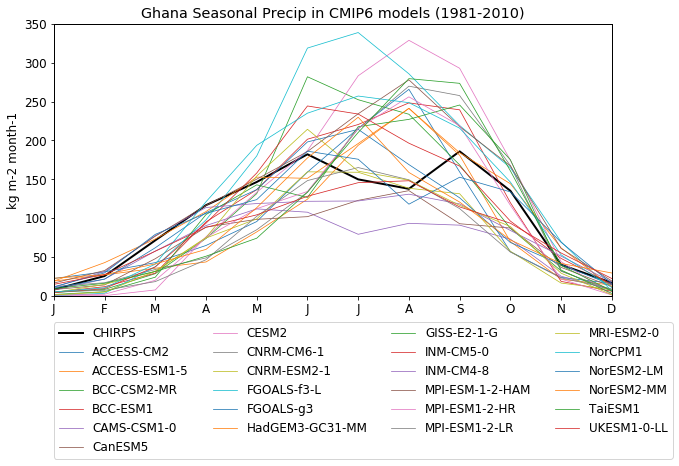

In [9]:
#path = '/home/users/jcabaker/agri_hackthon_cmip6/seasonal_precip_all_cmip6.png'
#df = pd.read_csv(path + 'seasonal_precip_ghana_cmip6_models_trim.csv', index_col=0)

# if you want to read all the models read data below
path = '/home/users/jcabaker/agri_hackthon_cmip6/seasonal_precip_all_cmip6.png'
df = pd.read_csv(path + 'seasonal_precip_ghana_cmip6_models.csv', index_col=0)

# plot data

# font settings
s = 12
font = {'weight' : 'normal',
        'size'   : s,
        'serif': 'Arial'}

plt.rc('font', **font)
plt.rc('axes', linewidth=1)

# figure set up
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
x = range(1, 12+1)

namelist = []
lines = []
for ds in df.columns:
    print(ds)
    y = df[ds].values
    
    if ds == 'CHIRPS':
        col = 'k'
        lw = 2
        lines += ax.plot(x, y, ls='-', lw=lw, color=col)
    else:
        lines += ax.plot(x, y, ls='-', lw=0.75)
    namelist.append(ds)
    
ax.set_xlim(1,12)
ax.set_ylim(0, 350)
ax.set_xticks(range(1, 12+1))
ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_ylabel(str(month_cube.units))
ax.set_title('Ghana Seasonal Precip in CMIP6 models (1981-2010)')
plt.legend(lines, namelist, loc=(0, -0.6), ncol=4)

# change outpath to somewhere you have read permissions
outpath = '/home/users/jcabaker/agri_hackthon_cmip6/seasonal_precip_all_cmip6.png'
plt.savefig(outpath, dpi=300, bbox_inches='tight')

In [ ]:
print(df)
# save dataframe
# change outpath to somewhere you have save permissions
#outpath = '/home/users/jcabaker/agri_hackthon_cmip6/seasonal_precip_all_cmip6.png'
#df.to_csv(outpath + 'seasonal_precip_ghana_cmip6_models.csv')

Calculate Pearson correlations between each model and CHIRPS

In [13]:
from scipy.stats import pearsonr

corr_table = pd.DataFrame()
corr_table['models'] = models

rvals = []
pvals = []
for model in models:
    rval, pval = pearsonr(df.CHIRPS, df[model])
    #print(model, rval, pval)
    rvals.append(rval)
    pvals.append(pval)
corr_table['Seasonal_correlation'] = rvals
corr_table['pvals'] = pvals
print(corr_table)

             models  Seasonal_correlation         pvals
0        ACCESS-CM2              0.747833  5.162885e-03
1     ACCESS-ESM1-5              0.758383  4.251080e-03
2       BCC-CSM2-MR              0.859526  3.386490e-04
3          BCC-ESM1              0.917367  2.637764e-05
4       CAMS-CSM1-0              0.944025  3.937989e-06
5           CanESM5              0.909084  4.192696e-05
6             CESM2              0.845072  5.386860e-04
7        CNRM-CM6-1              0.804300  1.610764e-03
8       CNRM-ESM2-1              0.917906  2.555279e-05
9       FGOALS-f3-L              0.885193  1.291601e-04
10        FGOALS-g3              0.874560  1.974257e-04
11  HadGEM3-GC31-MM              0.891266  9.947097e-05
12      GISS-E2-1-G              0.893388  9.047254e-05
13        INM-CM5-0              0.906808  4.725790e-05
14        INM-CM4-8              0.938536  6.227846e-06
15  MPI-ESM-1-2-HAM              0.894773  8.494971e-05
16    MPI-ESM1-2-HR              0.850388  4.566